In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd

import requests
import time

from datetime import datetime, timedelta
from dateutil import parser
from matplotlib import gridspec, style
from urllib.request import urlopen
from scipy import signal
from scipy.signal import find_peaks


# Context 
- This Jupyterlab will go through the training set generation for train a ML algo for trading
- The code downloads the data from Binance REST API
    - We use 5 min resolution here as an example

### Pipeline

- Kline >>>> Get a rough long/short signal >>>> Filter good signals >>>> export the data for training


### Output
- the signals in a format [0,1]
- optimise for a given stoploss, TP, entry offset, and time limit for an order to fill 

In [9]:
#getting kline from binance

def get_kline(startTime,symbol='BTCUSDT',limit=1,interval='5m'):
    ############################################################
    #This module gets the kline data from binance
    #startTime: start time in milliseconds
    #symbol: symbol of the coin
    #limit: number of candles to be fetched
    #interval: interval of the candles
    #returns: dataframe with kline data
    #Note : This is used for 5min data, you can change the interval in the get_kline function 
    ############################################################
    data = requests.get('https://fapi.binance.com/fapi/v1/klines', params={"symbol" : symbol,
                                                        "interval" : interval, 
                                                        "startTime" : startTime,
                                                        "endTime"   : startTime+(500*5*60*1000),
                                                        "limit": limit}).json()
    
    data  = pd.DataFrame(data,columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_vol', 'no_of_trades', 'tb_base_vol', 'tb_quote_vol', 'ignore' ])
    data.iloc[:,1:]=data.iloc[:,1:].astype(float)
    data['time'] = pd.to_datetime(data['timestamp'], unit='ms')
    return data

def get_kline_data(no_days=3):
    ############################################################
    #This module gets the data from binance and merges it
    #into a single dataframe and returns it
    #no_days: number of days of data to be fetched
    #returns: dataframe with kline data
    #Note: This is used for 5min data, you can change the interval in the get_kline function and n_loops accordingly
    ############################################################
    # Get the current time
    now = datetime.now()
    # Subtract 29 days from the current time
    thirty_days_ago = now - timedelta(days=no_days)
    # Convert the datetime object to a Unix timestamp in milliseconds
    timestamp_ms = int(thirty_days_ago.timestamp() * 1000)
    # Convert timestamp in milliseconds to a UTC datetime object
    timestamp_seconds = timestamp_ms / 1000  # convert milliseconds to seconds
    dt_object_utc = datetime.utcfromtimestamp(timestamp_seconds)
    print(f'{no_days} days lookback:',dt_object_utc)

    #Calcualte the number of loops required to get 30 days of data with 5 min candles
    mins = no_days*24*60 # no of days in mins
    n_loops = int(mins/(5*500))

    kline = get_kline(startTime=timestamp_ms,limit=500,symbol='BTCUSDT')
    for i in range(n_loops):
        kline_temp = get_kline(startTime=kline['timestamp'].values[-1],limit=500,symbol='BTCUSDT')
        kline=pd.concat([kline,kline_temp]).drop_duplicates().reset_index(drop=True)
    
    return kline


In [10]:
kline = get_kline_data(no_days=7) #download the data

7 days lookback: 2023-04-19 16:52:20.094000


### Now we get the entry for longs and shorts 
get the signal data from the kline data using the peakfinder

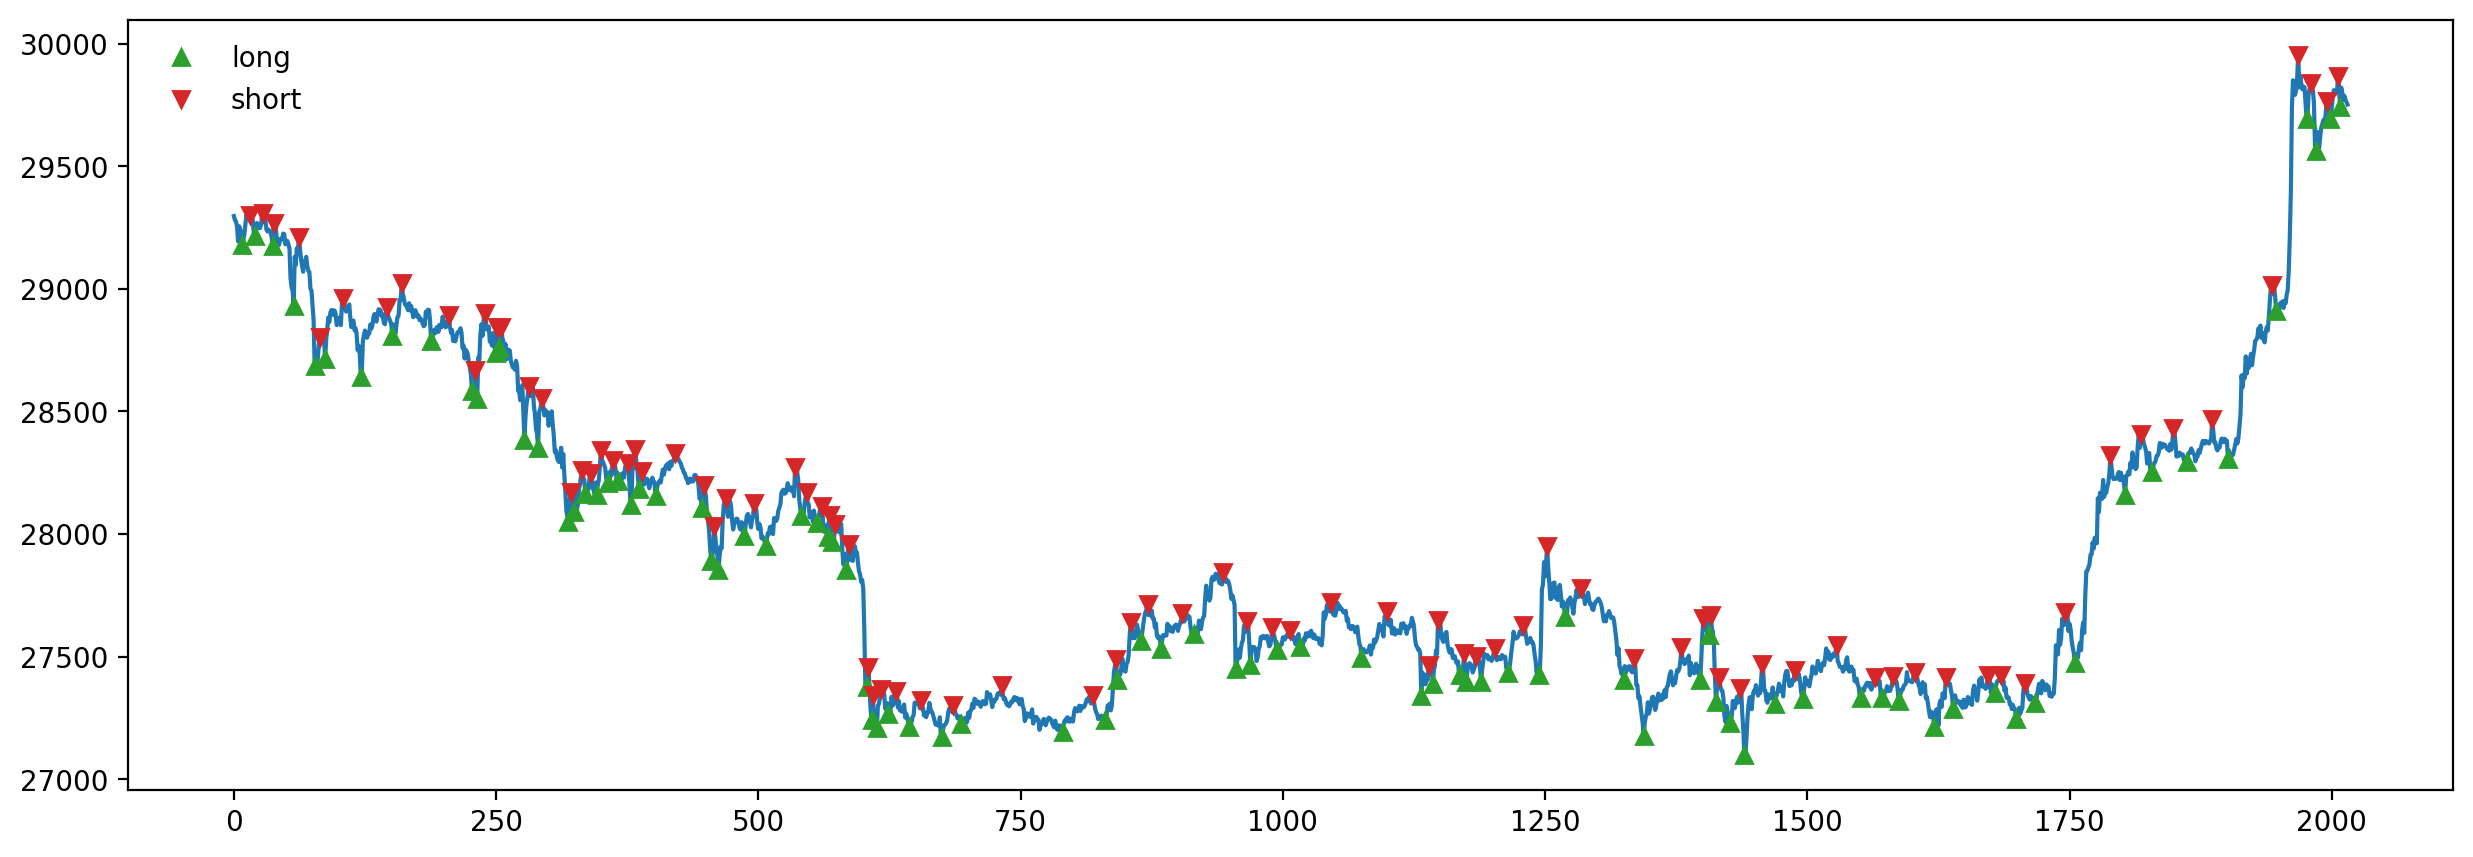

In [11]:
#prominence is the minimum height of the peak
prom_val = 70 #change this to get more or less signals

#find bottom peaks for long signals
long_peaks, _ = find_peaks(-kline['close'], prominence=prom_val)
# Create a boolean mask
mask = np.zeros_like(kline['close'], dtype=bool)
mask[long_peaks] = True
long_signals = mask

#now for short signals
short_peaks, _ = find_peaks(kline['close'], prominence=prom_val)
# Create a boolean mask
mask = np.zeros_like(kline['close'], dtype=bool)
mask[short_peaks] = True
short_signals = mask


plt.figure(figsize=(15,5))
plt.plot(kline['close'].values)
plt.plot(long_peaks , kline['close'].values[long_peaks] , "^",c='tab:green',label='long')
plt.plot(short_peaks, kline['close'].values[short_peaks], "v",c='tab:red',label='short')
plt.legend(frameon=False)
plt.show()


### Now we filter bad signals
- We need to find the time when the price crosses the signal price.
- We assume that the price is filled after the signal is generated.


RR 2.0:1
# signals          : 87
# filled orders    : 86
% actually filled orders    : 0.04 %
Win rate (long)      : 32.93 %
Win rate (optimised) : 32.93 %

 🤖 Summary number of win signals per day
             signal_price     close    stop_loss      target  Win
signal_time                                                      
2023-04-19       145182.3  145182.3  143004.5655  149537.769    0
2023-04-20       455197.0  455197.0  448369.0450  468852.910    0
2023-04-21       500473.0  500473.0  492965.9050  515487.190    4
2023-04-22       218920.1  218920.1  215636.2985  225487.703    4
2023-04-23       301851.4  301851.4  297323.6290  310906.942    0
2023-04-24       300929.0  300929.0  296415.0650  309956.870    6
2023-04-25       274017.9  274017.9  269907.6315  282238.437   10
2023-04-26       204190.9  204190.9  201128.0365  210316.627    3


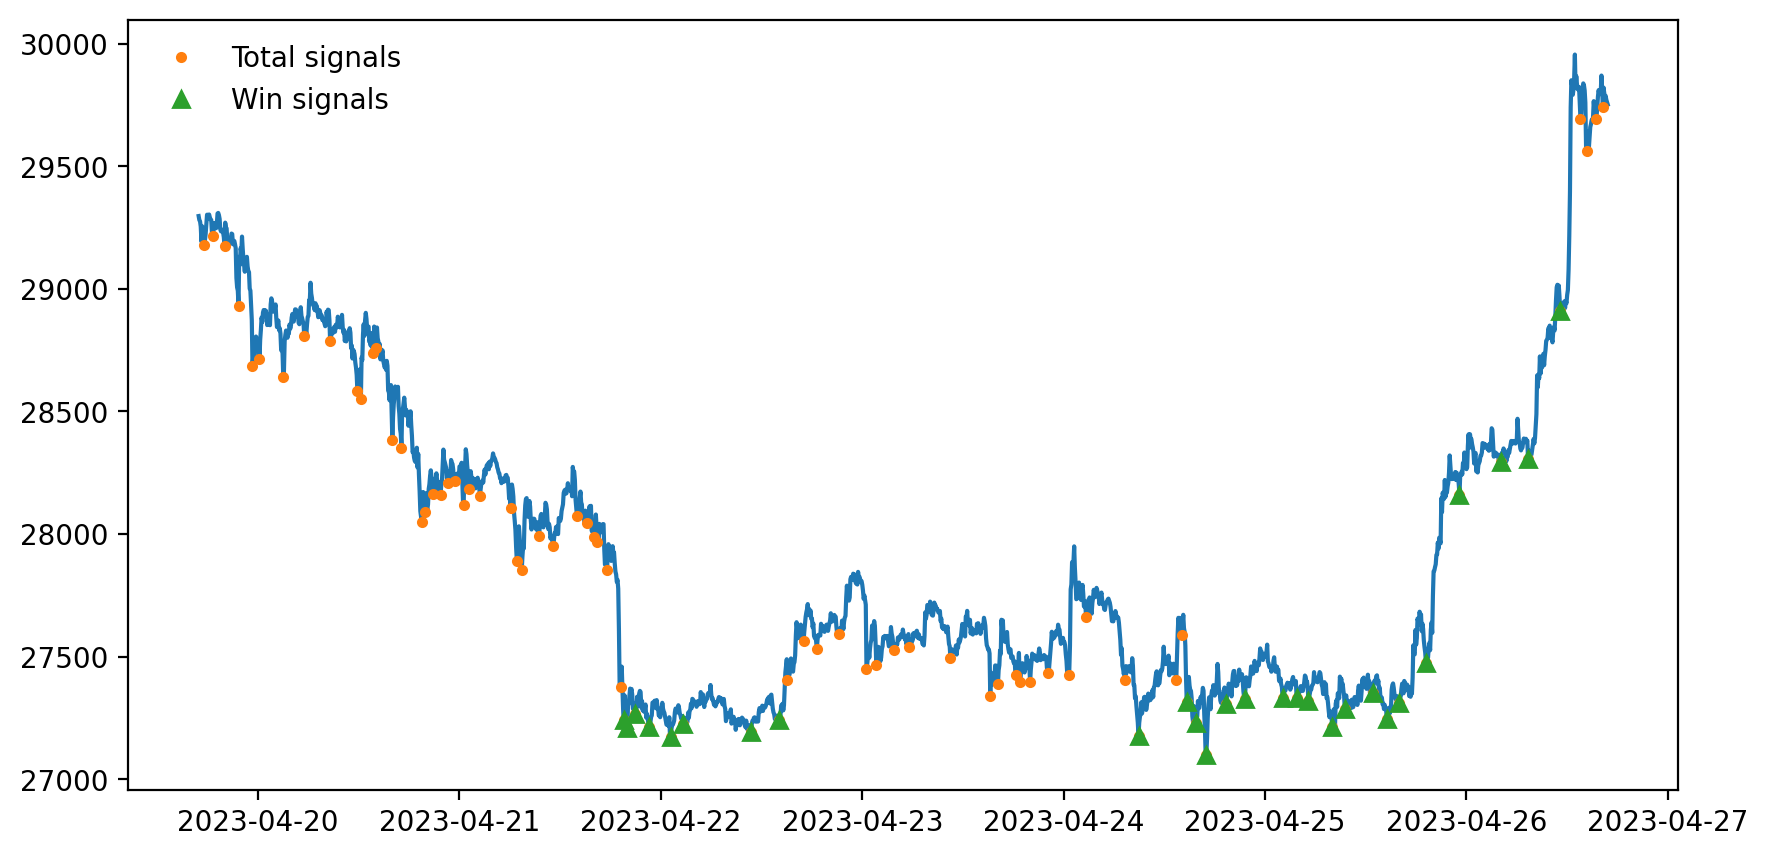

RR 2.0:1
# signals          : 86
# filled orders    : 86
% actually filled orders    : 0.04 %
Win rate (short)      : 45.12 %
Win rate (optimised) : 45.12 %

 🤖 Summary number of win signals per day
             signal_price     close    stop_loss      target  Win
signal_time                                                      
2023-04-19       145898.9  145898.9  148087.3835  141521.933    5
2023-04-20       429542.1  429542.1  435985.2315  416655.837   15
2023-04-21       531215.7  531215.7  539183.9355  515279.229   14
2023-04-22       220394.2  220394.2  223700.1130  213782.374    1
2023-04-23       303577.8  303577.8  308131.4670  294470.466    0
2023-04-24       275796.0  275796.0  279932.9400  267522.120    2
2023-04-25       275484.4  275484.4  279616.6660  267219.868    0
2023-04-26       233750.2  233750.2  237256.4530  226737.694    0


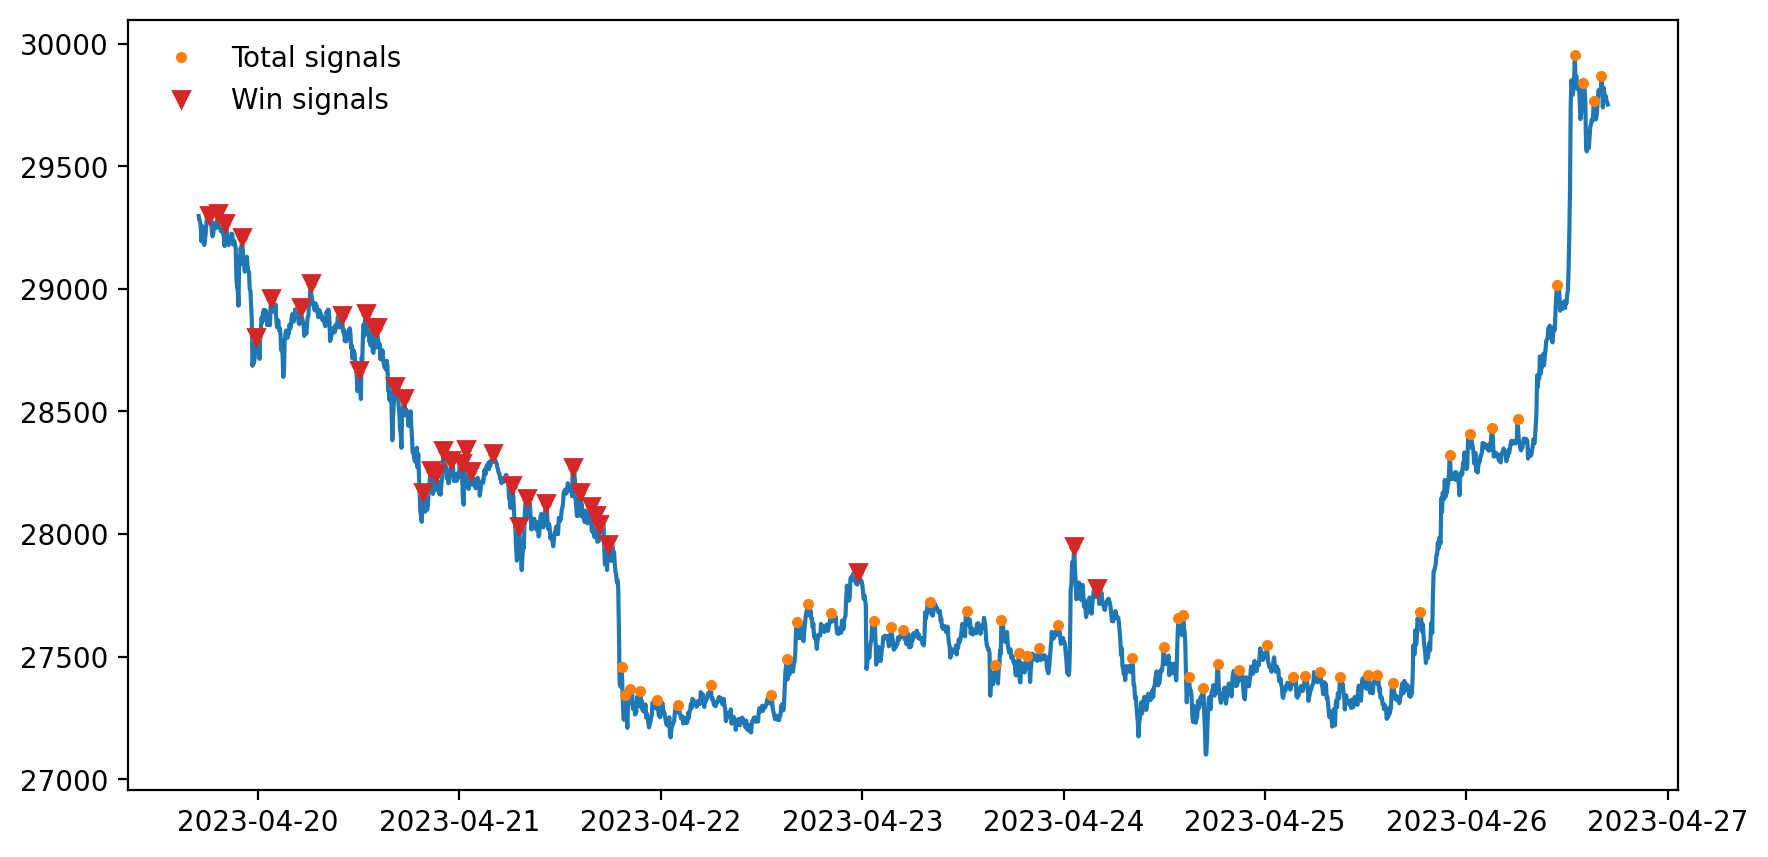

In [12]:
#here are the functions for backtesting the signals

def long_signal_filter(data,
                       long_filter,
                       entry_offset= 0.0, # 0.0% entry offset of a signal price
                       risk = 0.015,      #1.5%
                       RR =   2.,         #2:1
                       time_lim = 600     #time limit for an order to fill in minutes
                       ):

    #create a dataframe with the signal prices to backtest
    long_df = pd.DataFrame((1+entry_offset)*kline['close'][long_filter].values,columns=['signal_price']) 


    long_df['close']        = data['close'][long_signals].values
    long_df['stop_loss']    = long_df['signal_price']*(1-risk)
    long_df['target']       = long_df['signal_price']*(1+risk*RR)
    long_df['signal_time']  = data['timestamp'][long_signals].values

    ######## entry time############
    entry_time = []
    for i in range(len(long_df)):

        #we need to find the time when the price crosses the signal price
        #we assume that the price is filled after the signal is generated

        lookback_data        = data [data['timestamp']>long_df.iloc[i]['signal_time']] 
        entry_filled_time    = lookback_data['timestamp'][lookback_data['low']<=long_df.iloc[i]['signal_price']]
        if len(entry_filled_time.values) != 0:
            entry_time.append(entry_filled_time.values[0])
            #print(entry_time.values[0])
        else:
            entry_time.append(np.inf)
            
    long_df['entry_time'] = entry_time

    ######## stop loss & target time############
    stop_loss_time=[]
    target_time=[]
    for i in range(len(long_df)):
        lookback_data  = data[data['timestamp']>=long_df.iloc[i]['entry_time']] 
        
        stop_time      = lookback_data['timestamp'][lookback_data['low']<=long_df.iloc[i]['stop_loss']]
        
        if len(stop_time.values) != 0:
            stop_loss_time.append(stop_time.values[0])
        else:
            #stop_loss_time.append(np.NaN)
            stop_loss_time.append(np.inf)
        
        #only allow the target to happen after the signal
        lookback_data  = data[data['timestamp']>long_df.iloc[i]['entry_time']] 
        tar_hit_time = lookback_data['timestamp'][lookback_data['high']>=long_df.iloc[i]['target']]
        
        if len(tar_hit_time.values) != 0:
            #print((tar_hit_time.values[0]-long_df.iloc[i]['entry_time'])/1000/60)
            target_time.append(tar_hit_time.values[0])
        else:
            target_time.append(np.inf)
            
    long_df['stop_loss_time'] = stop_loss_time
    long_df['target_time']    = target_time

    ##filtering pending orders
    long_df = long_df[ (long_df.entry_time != np.inf)] 
    no_pending=len(long_df [(long_df.stop_loss_time == np.inf)&(long_df.target_time == np.inf)])
    #long_df.head()
    long_df['Win']= (long_df.stop_loss_time > long_df.target_time).astype(int)
    long_df = long_df[long_df['target_time']!=0] 



    long_df['entry_time']   = pd.to_datetime(long_df['entry_time'], unit='ms')
    long_df['signal_time']  = pd.to_datetime(long_df['signal_time'], unit='ms')
    long_df['stop_loss_time'] = pd.to_datetime(long_df['stop_loss_time'][long_df['stop_loss_time']!=np.inf], unit='ms')
    long_df['target_time']    = pd.to_datetime(long_df['target_time'][long_df['target_time']!=np.inf], unit='ms')

    print(f'RR {RR}:1')
    print('# signals          :',sum(long_filter))
    print('# filled orders    :',len(long_df))


    true_winrate = sum(long_df.Win)/ (len(long_df)-no_pending)
    time_filter  = (long_df.entry_time -long_df.signal_time ) <pd.Timedelta(time_lim, "m")#< pd.Timedelta(0.1, "h")

    true_winrate_opt =  sum(long_df[time_filter].Win)/ (len(long_df[time_filter])-no_pending)
    print('% actually filled orders    :',np.round((sum(time_filter)-no_pending)/(len(long_filter)-no_pending),2),'%')

    print(f'Win rate (long)      : {np.round(true_winrate*100,2)} %')
    print(f'Win rate (optimised) : {np.round(true_winrate_opt*100,2)} %')

    print('\n 🤖 Summary number of win signals per day')
    grouped = long_df.groupby(pd.Grouper(key='signal_time', freq='D'))
    print(grouped.sum())

    plt.figure(figsize=(10,5))
    plt.plot(kline['time'],kline['close'])
    plt.plot(long_df.signal_time,long_df['close'],'.',label='Total signals')
    plt.plot(long_df.signal_time[long_df['Win']==1],long_df['close'][long_df['Win']==1],'^',label='Win signals')
    plt.legend(frameon=False)
    plt.show()


    long_df = long_df[long_df['Win']==1]
    #rename long_df's 'signal_time' to 'time' to merge with kline
    long_df = long_df.rename(columns={'signal_time': 'time'})
    #merge kline and long_df
    df_A = kline['time'] 
    df_B = long_df['time']
    #this is the signals index in the kline dataframe
    idx = df_A[df_A.isin(df_B)].index

    # Create a boolean mask
    mask = np.zeros_like(kline['close'], dtype=bool)
    mask[idx] = True
    mask.shape
    mask.astype(int)
    return mask

def short_signal_filter(data,
                       short_filter,
                       entry_offset= 0.0, # 0.0% entry offset of a signal price
                       risk = 0.015,      #1.5%
                       RR =   2.,         #2:1
                       time_lim = 600     #time limit for an order to fill in minutes
                       ):

    #create a dataframe with the signal prices to backtest
    short_df = pd.DataFrame((1+entry_offset)*kline['close'][short_filter].values,columns=['signal_price']) 


    short_df['close']        = data['close'][short_signals].values
    short_df['stop_loss']    = short_df['signal_price']*(1+risk)
    short_df['target']       = short_df['signal_price']*(1-risk*RR)
    short_df['signal_time']  = data['timestamp'][short_signals].values

    ######## entry time############
    entry_time = []
    for i in range(len(short_df)):

        #we need to find the time when the price crosses the signal price
        #we assume that the price is filled after the signal is generated

        lookback_data        = data [data['timestamp']>short_df.iloc[i]['signal_time']] 
        entry_filled_time    = lookback_data['timestamp'][lookback_data['high']>=short_df.iloc[i]['signal_price']]
        if len(entry_filled_time.values) != 0:
            entry_time.append(entry_filled_time.values[0])
            #print(entry_time.values[0])
        else:
            entry_time.append(np.inf)
            
    short_df['entry_time'] = entry_time

    ######## stop loss & target time############
    stop_loss_time=[]
    target_time=[]
    for i in range(len(short_df)):
        lookback_data  = data[data['timestamp']>=short_df.iloc[i]['entry_time']] 
        
        stop_time      = lookback_data['timestamp'][lookback_data['high']>=short_df.iloc[i]['stop_loss']]
        
        if len(stop_time.values) != 0:
            stop_loss_time.append(stop_time.values[0])
        else:
            #stop_loss_time.append(np.NaN)
            stop_loss_time.append(np.inf)
        
        #only allow the target to happen after the signal
        lookback_data  = data[data['timestamp']>short_df.iloc[i]['entry_time']] 
        tar_hit_time = lookback_data['timestamp'][lookback_data['low']<=short_df.iloc[i]['target']]
        
        if len(tar_hit_time.values) != 0:
            #print((tar_hit_time.values[0]-short_df.iloc[i]['entry_time'])/1000/60)
            target_time.append(tar_hit_time.values[0])
        else:
            target_time.append(np.inf)
            
    short_df['stop_loss_time'] = stop_loss_time
    short_df['target_time']    = target_time

    ##filtering pending orders
    short_df = short_df[ (short_df.entry_time != np.inf)] 
    no_pending=len(short_df [(short_df.stop_loss_time == np.inf)&(short_df.target_time == np.inf)])
    #short_df.head()
    short_df['Win']= (short_df.stop_loss_time > short_df.target_time).astype(int)
    short_df = short_df[short_df['target_time']!=0] 



    short_df['entry_time']   = pd.to_datetime(short_df['entry_time'], unit='ms')
    short_df['signal_time']  = pd.to_datetime(short_df['signal_time'], unit='ms')
    short_df['stop_loss_time'] = pd.to_datetime(short_df['stop_loss_time'][short_df['stop_loss_time']!=np.inf], unit='ms')
    short_df['target_time']    = pd.to_datetime(short_df['target_time'][short_df['target_time']!=np.inf], unit='ms')

    print(f'RR {RR}:1')
    print('# signals          :',sum(short_filter))
    print('# filled orders    :',len(short_df))


    true_winrate = sum(short_df.Win)/ (len(short_df)-no_pending)
    time_filter  = (short_df.entry_time -short_df.signal_time ) <pd.Timedelta(time_lim, "m")#< pd.Timedelta(0.1, "h")

    true_winrate_opt =  sum(short_df[time_filter].Win)/ (len(short_df[time_filter])-no_pending)
    print('% actually filled orders    :',np.round((sum(time_filter)-no_pending)/(len(short_filter)-no_pending),2),'%')

    print(f'Win rate (short)      : {np.round(true_winrate*100,2)} %')
    print(f'Win rate (optimised) : {np.round(true_winrate_opt*100,2)} %')

    print('\n 🤖 Summary number of win signals per day')
    grouped = short_df.groupby(pd.Grouper(key='signal_time', freq='D'))
    print(grouped.sum())

    plt.figure(figsize=(10,5))
    plt.plot(kline['time'],kline['close'])
    plt.plot(short_df.signal_time,short_df['close'],'.',label='Total signals')
    plt.plot(short_df.signal_time[short_df['Win']==1],short_df['close'][short_df['Win']==1],'v',c='tab:red',label='Win signals')
    plt.legend(frameon=False)
    plt.show()


    short_df = short_df[short_df['Win']==1]
    #rename short_df's 'signal_time' to 'time' to merge with kline
    short_df = short_df.rename(columns={'signal_time': 'time'})
    #merge kline and short_df
    df_A = kline['time'] 
    df_B = short_df['time']
    #this is the signals index in the kline dataframe
    idx = df_A[df_A.isin(df_B)].index

    # Create a boolean mask
    mask = np.zeros_like(kline['close'], dtype=bool)
    mask[idx] = True
    mask.shape
    mask.astype(int)
    return mask


entry_offset = 0.0 # 0.0% entry offset of a signal price
risk = 0.015 #1.5%
RR =   2. #2:1
time_lim = 600 #time limit for an order to fill in minutes


long_mask = long_signal_filter(kline,long_signals)
short_mask = short_signal_filter(kline,short_signals)

In [13]:
#add signals to data
kline['long_signals'] = long_mask.astype(int)
kline['short_signals'] = short_mask.astype(int)

#export data  to csv
kline.to_csv(f'BTC_5m_SL{risk*100}_{RR}.csv',index=False)


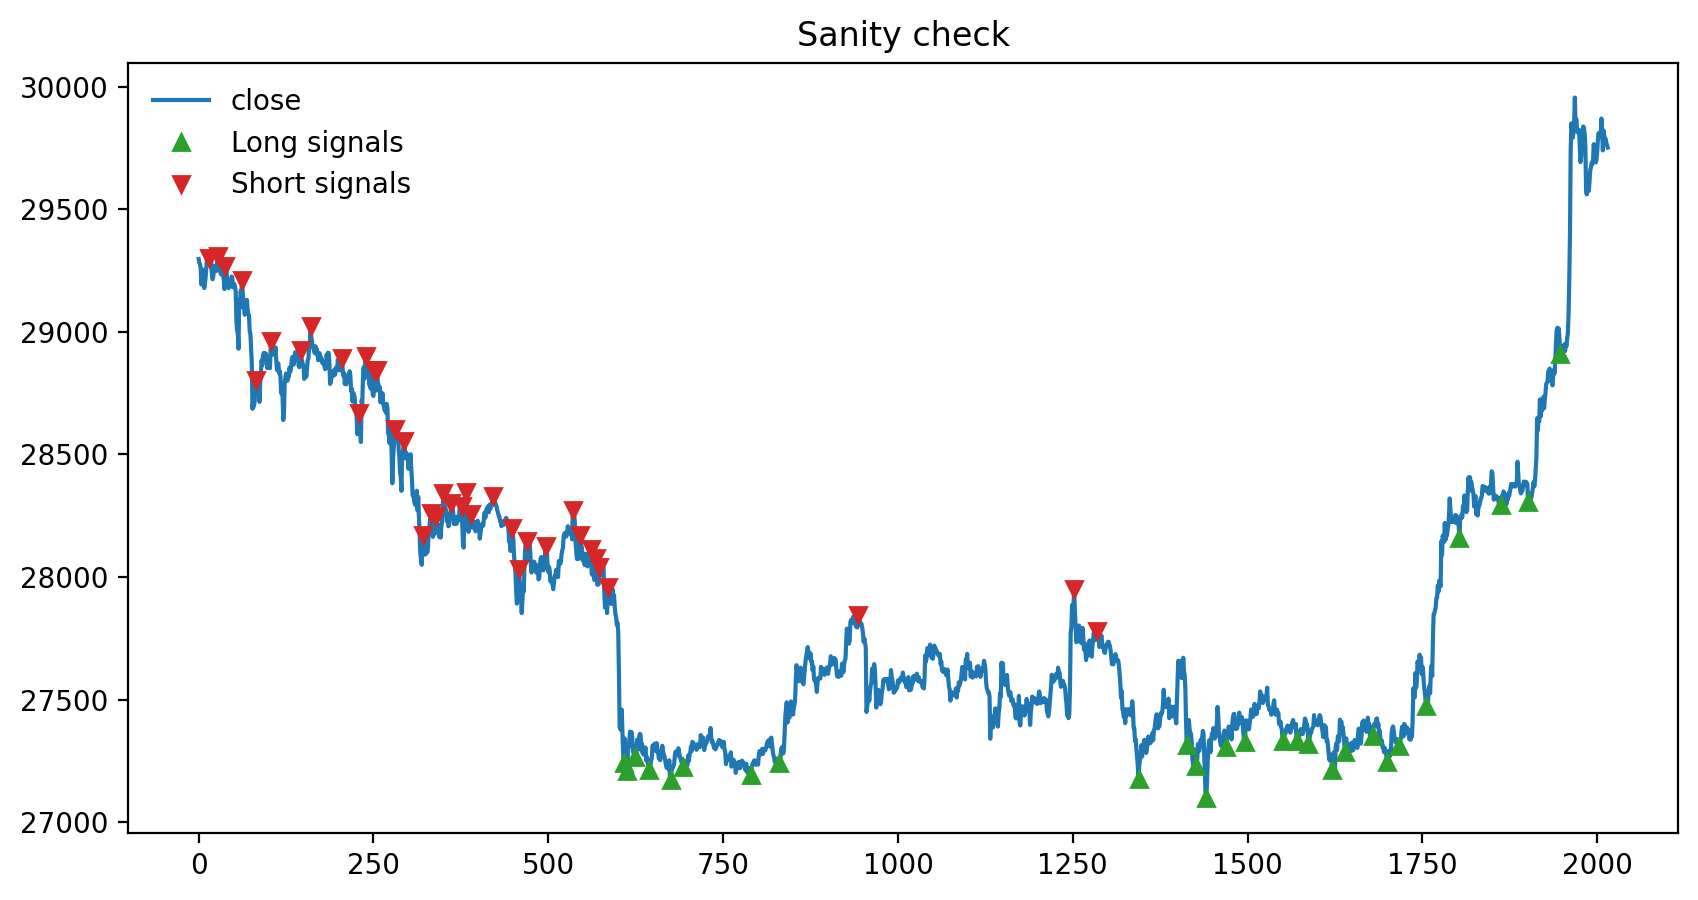

,timestamp,open,high,low,close,volume,close_time,quote_vol,no_of_trades,tb_base_vol,tb_quote_vol,ignore,time,long_signals,short_signals
0,1681923300000,29299.9,29315.0,29294.5,29296.4,374.163,1.681924e+12,1.096506e+07,6048.0,163.831,4.801140e+06,0.0,2023-04-19 16:55:00,0,0
1,1681923600000,29296.4,29300.3,29260.0,29280.2,1188.743,1.681924e+12,3.480694e+07,13258.0,392.546,1.149485e+07,0.0,2023-04-19 17:00:00,0,0
2,1681923900000,29280.3,29309.7,29274.8,29274.8,834.072,1.681924e+12,2.443073e+07,10093.0,410.267,1.201782e+07,0.0,2023-04-19 17:05:00,0,0
3,1681924200000,29274.7,29283.1,29246.8,29253.4,1095.216,1.681924e+12,3.205112e+07,10630.0,351.601,1.028932e+07,0.0,2023-04-19 17:10:00,0,0
4,1681924500000,29253.4,29277.7,29166.9,29192.7,3961.635,1.681925e+12,1.157821e+08,27164.0,1646.918,4.813536e+07,0.0,2023-04-19 17:15:00,0,0


In [14]:
##############################
#####sanity check
##############################
plt.figure(figsize=(10,5))
plt.title('Sanity check')
kline['close'].plot()
plt.plot(kline['close'][kline['long_signals']==1],'^',c='tab:green',label='Long signals')
plt.plot(kline['close'][kline['short_signals']==1],'v',c='tab:red',label='Short signals')
plt.legend(frameon=False)
plt.show()

kline.head()